In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import jax
import jax.numpy as np

import numpy as onp
from numpy.polynomial.hermite import hermgauss

import inspect
import os
import sys
import time

onp.random.seed(3452453)

In [2]:
from bnpmodeling_runjingdev import result_loading_utils

from bnpreg_runjingdev import genomics_data_utils
from bnpreg_runjingdev import regression_mixture_lib
from bnpreg_runjingdev import regression_optimization_lib as reg_optim_lib
from bnpreg_runjingdev import regression_posterior_quantities as reg_posterior_quantities

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
import regression_plotting_utils


# Load data

In [4]:
# Set bnp_data_repo to be the location of a clone of the repo
# https://github.com/NelleV/genomic_time_series_bnp
bnp_data_repo = '../../../genomic_time_series_bnp' 

genome_data, timepoints, gamma, gamma_info, regressors_transformed = \
    genomics_data_utils.load_and_tranform_data(bnp_data_repo)

Loading data from:  ../../../genomic_time_series_bnp/data/shoemaker2015reprocessed


In [5]:
n_genes = genome_data.shape[0]
reg_dim = gamma.shape[1]

### Plot data and predictions 

In red are predictions by the transformed regression coefficients

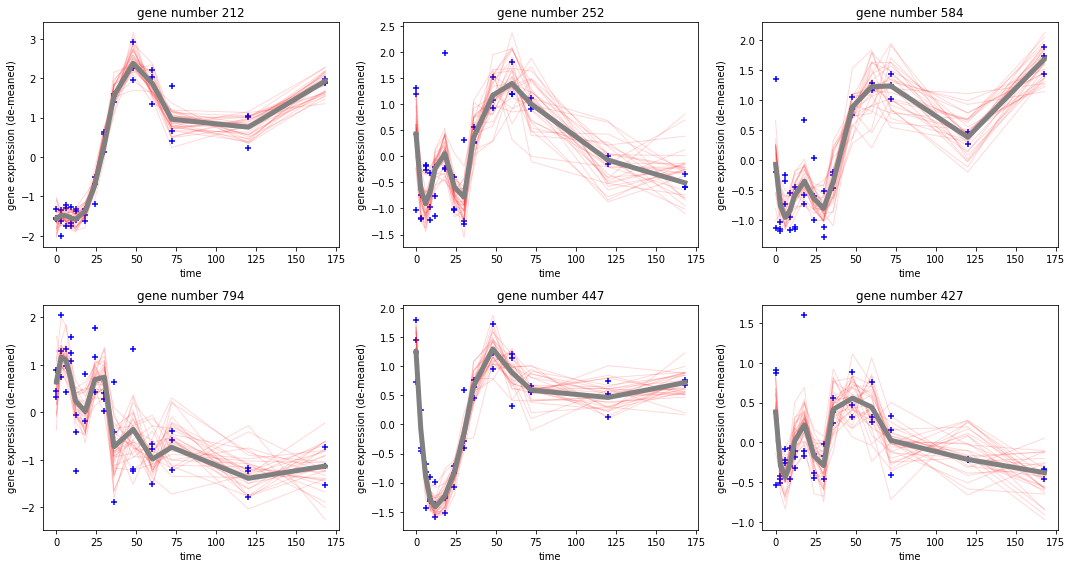

In [6]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

gene_indx = onp.random.choice(n_genes, 6)

for i in range(6):

    n = gene_indx[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3]
    
    regression_plotting_utils.plot_data(timepoints, genome_data[n], this_plot, demean = True)
    regression_plotting_utils.plot_prediction_line_and_sample(timepoints, 
                                                              regressors_transformed, 
                                                              gamma[n],
                                                              gamma_info[n],
                                                              this_plot)
    
    this_plot.set_title('gene number {}'.format(n))
    this_plot.set_xlabel('time')
    this_plot.set_ylabel('gene expression (de-meaned)')


f.tight_layout()


### The gammas are what we will cluster

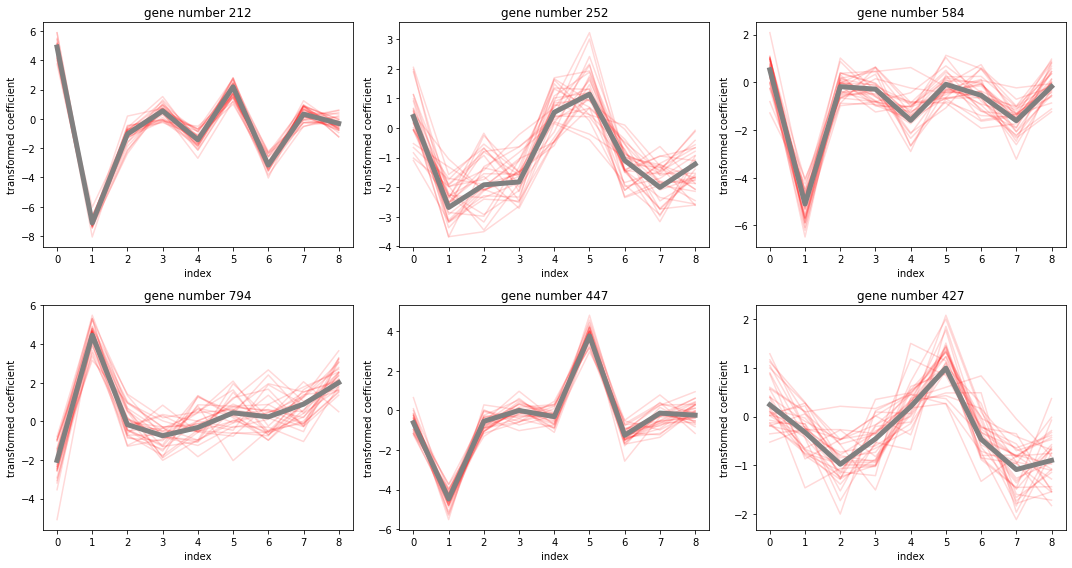

In [7]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

for i in range(6):
    n = gene_indx[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3] 
    
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number {}'.format(n))

    # draw from the variational distribution, to plot uncertainties
    for j in range(30): 
        transformed_gamma_draw = onp.random.multivariate_normal(
            gamma[n, :], \
             np.linalg.inv(gamma_info[n]))

        axarr[int(np.floor(i / 3)), i % 3].plot(transformed_gamma_draw, 
                                                color = 'red', alpha = 0.15);
        
    this_plot.plot(gamma[n, :], color = 'grey', linewidth = 5);

f.tight_layout()


In [8]:
from sklearn.decomposition import PCA

In [9]:
pca_fit = PCA()
pca_fit.fit(gamma)
pc_iris_obs = pca_fit.transform(gamma)


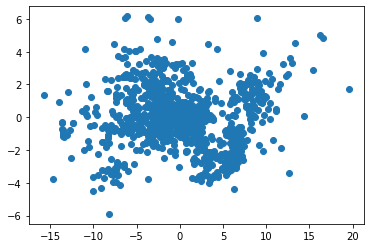

In [10]:
plt.scatter(pc_iris_obs[:, 0], 
         pc_iris_obs[:, 1])

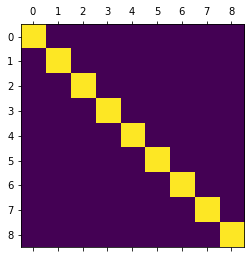

In [11]:
plt.matshow(gamma_info[1])

(array([ 90., 141., 142., 151., 153., 148.,  85.,  65.,  24.,   1.]),
 array([0.3394987 , 1.17343269, 2.00736667, 2.84130066, 3.67523464,
        4.50916863, 5.34310262, 6.1770366 , 7.01097059, 7.84490457,
        8.67883856]),
 <BarContainer object of 10 artists>)

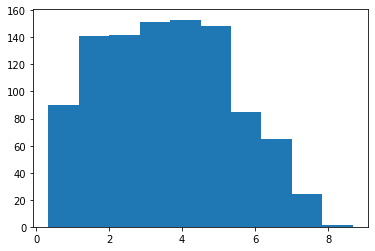

In [12]:
plt.hist(gamma_info[:, 0, 0])

# Prior parameters

In [13]:
prior_params_dict, vb_params_paragami = regression_mixture_lib.get_default_prior_params(reg_dim)

In [16]:
prior_params_dict['dp_prior_alpha'] = 0.01

# VB parameters

In [17]:
k_approx = 50
vb_params_dict, vb_params_paragami = regression_mixture_lib.get_vb_params_paragami_object(reg_dim, k_approx)

In [18]:
vb_params_dict['centroids'].shape

(50, 9)

### Gauss hermite 

In [19]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

# convert to jax arrays
gh_loc, gh_weights = np.array(gh_loc), np.array(gh_weights)

# Optimize

In [20]:
def get_loss(vb_params_dict): 

    return regression_mixture_lib.get_kl(gamma, 
                                         gamma_info,
                                         vb_params_dict,
                                         prior_params_dict,
                                         gh_loc,
                                         gh_weights)


In [21]:
get_loss(vb_params_dict)

DeviceArray(2688.58826585, dtype=float64)

In [22]:
vb_params_dict = reg_optim_lib.set_params_w_kmeans(gamma, gamma_info,
                                                   vb_params_dict,
                                                   vb_params_paragami,
                                                   prior_params_dict['dp_prior_alpha'], 
                                                   gh_loc, gh_weights)

running k-means ... 
initializing sticks ...
(49, 2)


In [23]:
get_loss(vb_params_dict)

DeviceArray(-84703.70696566, dtype=float64)

In [24]:
vb_opt_dict, vb_opt, ez_opt, out, optim_time = \
    reg_optim_lib.optimize_regression_mixture(gamma,
                                              gamma_info, 
                                              vb_params_dict,
                                              vb_params_paragami,
                                              prior_params_dict, 
                                              gh_loc, 
                                              gh_weights, 
                                              run_newton=True)

compiling objective and derivatives ... 
done. Compile time: 9.713sec
Running L-BFGS-B ...
L-BFGS-B time: 1.783sec
Running trust-ncg ... 
Newton time: 5.403sec
Optimization terminated successfully.
done. 


In [25]:
out.fun

array(-84891.11505111)

In [26]:
get_loss(vb_opt_dict)

DeviceArray(-84891.11505111, dtype=float64)

# Check out fit

In [27]:
def get_e_num_obs_per_cluster(vb_params_free): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    ez = reg_posterior_quantities.get_optimal_z_from_vb_dict(gamma, gamma_info, vb_params_dict,
                                                             gh_loc, gh_weights)
    
    return ez.sum(0)

In [28]:
def get_mixture_weights(vb_params_free): 

    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    return reg_posterior_quantities.get_e_mixture_weights_from_vb_dict(vb_params_dict, gh_loc, gh_weights)

In [29]:
e_num_obs_per_cluster = get_e_num_obs_per_cluster(vb_opt)
mixture_weights = get_mixture_weights(vb_opt)

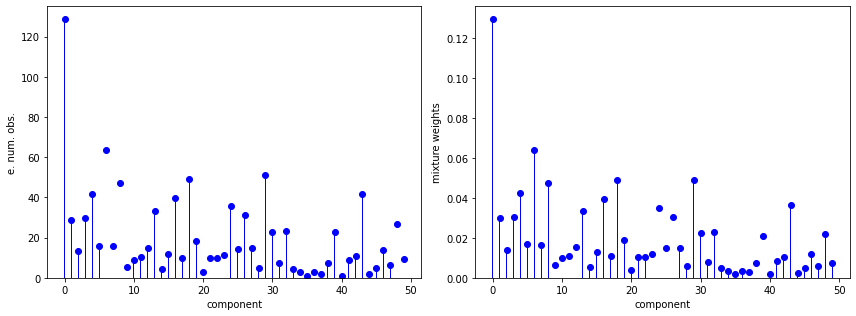

In [30]:
# plot mixture weights and allocations

fig, axarr = plt.subplots(1, 2, figsize = (12, 4.5))

result_loading_utils._plot_weights(e_num_obs_per_cluster, 
                                   axarr[0])

result_loading_utils._plot_weights(mixture_weights, 
                                   axarr[1])


axarr[0].set_ylabel('e. num. obs.')
axarr[1].set_ylabel('mixture weights')
    
fig.tight_layout()


In [31]:
len(np.unique(ez_opt.argmax(1)))

49

In [32]:
from bnpmodeling_runjingdev import exponential_families as ef

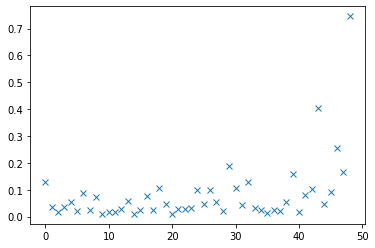

In [33]:
stick_means = ef.get_e_logitnormal(vb_opt_dict['stick_params']['stick_means'],
                              vb_opt_dict['stick_params']['stick_infos'],
                              gh_loc, gh_weights)

plt.plot(stick_means, 'x')

# Plot top centroids

In [30]:
top_clusters_sorted = np.argsort(-e_num_obs_per_cluster)

In [31]:
centroids = vb_opt_dict['centroids']

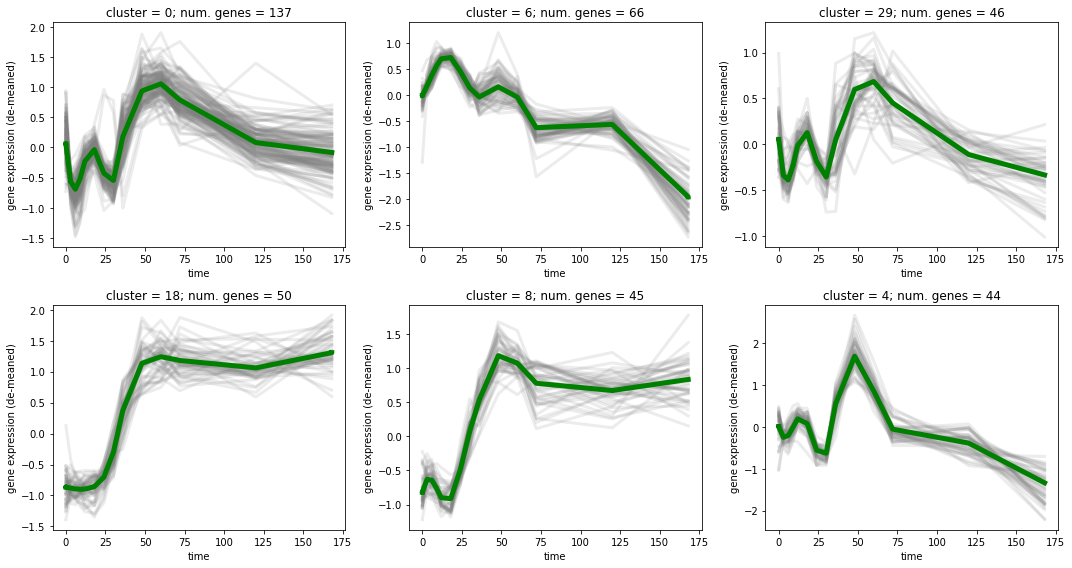

In [32]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

for i in range(6):
    which_cluster = top_clusters_sorted[i]
    which_genes = np.argwhere(ez_opt.argmax(1) == which_cluster).squeeze()
    
    this_plot = axarr[int(np.floor(i / 3)), i % 3]
    
    this_plot.set_title('cluster = {}; num. genes = {}'.format(which_cluster, len(which_genes)))
    this_plot.set_xlabel('time')
    this_plot.set_ylabel('gene expression (de-meaned)')

    # Plot genes in this cluster
    for n in which_genes: 
        regression_plotting_utils.plot_prediction_line(timepoints, 
                                                       regressors_transformed, 
                                                       gamma[n], 
                                                       ax = this_plot, 
                                                       alpha = 0.15, 
                                                       color = 'grey')
        
    # plot centroid
    regression_plotting_utils.plot_prediction_line(timepoints, 
                                                   regressors_transformed, 
                                                   centroids[which_cluster], 
                                                   ax = this_plot, 
                                                   linewidth = 5, 
                                                   color = 'green')
    


f.tight_layout()


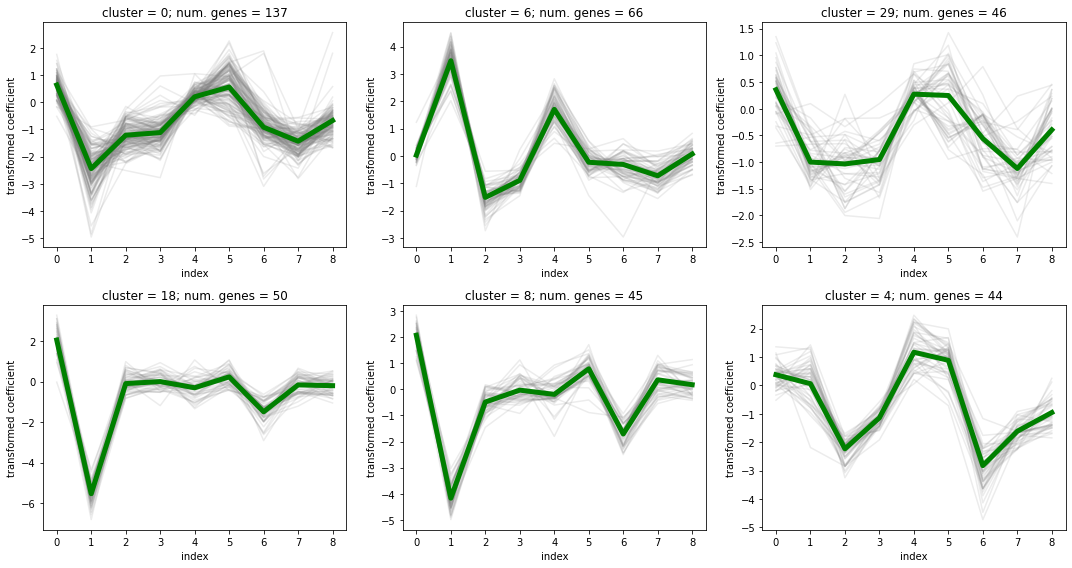

In [33]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

for i in range(6):
    which_cluster = top_clusters_sorted[i]
    which_genes = np.argwhere(ez_opt.argmax(1) == which_cluster).squeeze()
    
    this_plot = axarr[int(np.floor(i / 3)), i % 3]
    
    this_plot.set_title('cluster = {}; num. genes = {}'.format(which_cluster, len(which_genes)))
    this_plot.set_xlabel('index')
    this_plot.set_ylabel('transformed coefficient')
        
    # draw fitted coefficient
    for n in which_genes:
        this_plot.plot(gamma[n, :], alpha = 0.15, color = 'grey')
    
    # draw centroids
    this_plot.plot(centroids[which_cluster, :], linewidth = 5, color = 'green')
    
f.tight_layout()


# Plot a couple genes

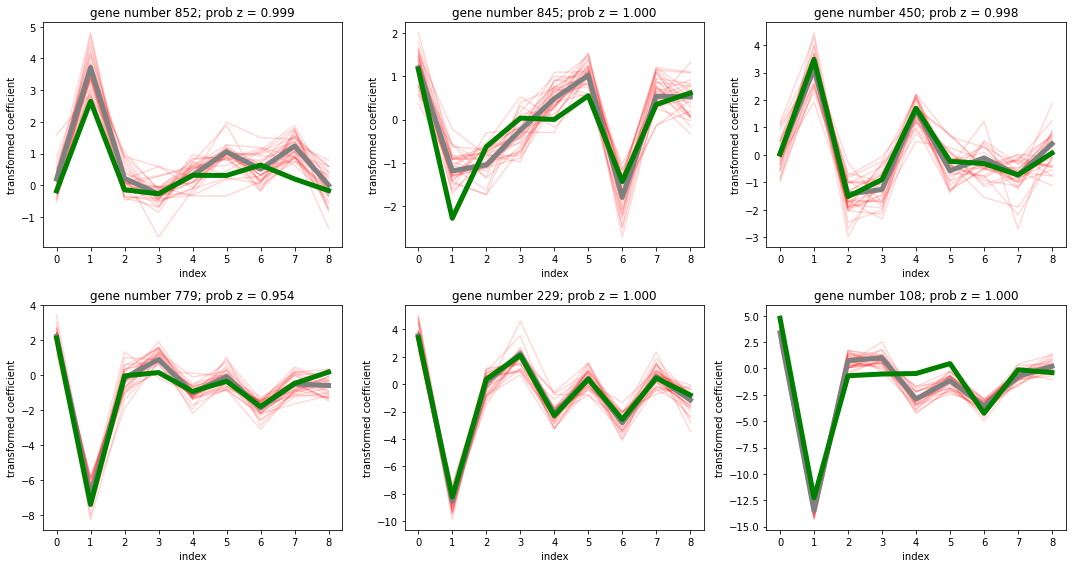

In [34]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

gene_indx = onp.random.choice(n_genes, 6)

for i in range(6):
    n = gene_indx[i]
    
    this_plot = axarr[int(np.floor(i / 3)), i % 3] 
    
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number ' + str(n) + \
                        '; prob z = {:.03f}'.format(ez_opt[n].max()))

    # draw from the variational distribution, to plot uncertainties
    for j in range(30): 
        transformed_gamma_draw = onp.random.multivariate_normal(
            gamma[n, :], \
             np.linalg.inv(gamma_info[n]))

        axarr[int(np.floor(i / 3)), i % 3].plot(transformed_gamma_draw, 
                                                color = 'red', alpha = 0.15);
    # plot mean    
    this_plot.plot(gamma[n, :], color = 'grey', linewidth = 5);
    
    # plot centroid 
    which_cluster = np.argmax(ez_opt[n])
    this_plot.plot(centroids[which_cluster, :], linewidth = 5, color = 'green')
    
f.tight_layout()


In [17]:
(ez_opt.argmax(1) == 29).sum()

DeviceArray(169, dtype=int64)

In [43]:
centroids = vb_opt_dict['centroids']
stick_means = vb_opt_dict['stick_params']['stick_means']
stick_infos = vb_opt_dict['stick_params']['stick_infos']

loglik_obs_by_nk = regression_mixture_lib.get_loglik_obs_by_nk(gamma, gamma_info, centroids) 

In [46]:
loglik_obs_by_nk[1]

DeviceArray([ -35.71407272,    4.46129507,  165.45424491,  176.0103402 ,
              241.44437278, -367.55059072,  168.36177516,  149.717564  ,
             -106.6397499 , -202.55124687,  303.97290325,  208.78477691,
             -245.02025484, -199.13066501,   87.52848569, -116.09088945,
              116.56169519,  133.54217502, -112.1674107 ,  236.39918546,
             -158.24049067,   49.63673369,   51.44029559,  -12.94596968,
               88.97101348, -156.79708752,  -55.2793089 ,   12.4903181 ,
               27.54789836,   72.97000193], dtype=float64)

In [37]:
gamma_info

array([[[ 1.60082284e+00,  1.28251549e-15, -1.24472907e-16, ...,
         -3.70084626e-16,  1.02940206e-15,  1.09851508e-16],
        [ 1.83819811e-15,  1.60082284e+00,  3.55636877e-17, ...,
          3.37855034e-16,  1.93377552e-16,  5.75437138e-15],
        [-1.08913794e-16,  1.06691063e-16,  1.60082284e+00, ...,
         -8.85535825e-15, -4.62327941e-16,  1.81708217e-15],
        ...,
        [-7.65730652e-16,  2.66727658e-16, -8.85091279e-15, ...,
          1.60082284e+00,  1.85431291e-15,  1.89307177e-15],
        [ 3.08681696e-16,  1.11136524e-16, -4.47880193e-16, ...,
          1.92293971e-15,  1.60082284e+00, -2.04004982e-16],
        [-6.23250155e-16,  5.56516145e-15,  1.83375265e-15, ...,
          2.95171662e-15, -4.68110513e-16,  1.60082284e+00]],

       [[ 1.71989670e+00,  1.28028169e-15, -1.10324875e-16, ...,
         -3.78439978e-16,  7.38278669e-16,  1.76391515e-16],
        [ 1.10581444e-15,  1.71989670e+00,  2.46306698e-16, ...,
          5.95241186e-16,  2.89923509e

In [33]:
ez_opt[0]

DeviceArray([1.98384868e-116, 2.20597227e-108, 7.48385966e-063,
             3.20251234e-049, 2.78950450e-032, 3.10339569e-244,
             2.77986343e-054, 9.08093681e-043, 3.20258442e-147,
             8.83818479e-194, 6.44246159e-004, 1.59643495e-022,
             1.39428594e-199, 9.47921946e-179, 1.28376637e-095,
             1.07286055e-150, 7.35545605e-066, 1.28397603e-058,
             2.90403778e-159, 9.99355754e-001, 3.65859752e-170,
             2.46199396e-086, 1.15834068e-092, 4.41600640e-141,
             1.29986408e-062, 1.34150936e-161, 9.68180725e-132,
             1.20432886e-108, 5.53816164e-105, 2.67093606e-087],            dtype=float64)

In [34]:
regression_mixture_lib.modeling_lib.get_e_log_cluster_probabilities(stick_means, stick_infos, gh_loc, gh_weights)

DeviceArray([-4.37840172, -2.63110116, -3.30856589, -2.82689623,
             -2.93292451, -3.98928552, -2.96484305, -2.75742465,
             -2.4804958 , -5.55066314, -3.41438941, -2.90730207,
             -3.57710994, -3.6744619 , -3.91343981, -4.31980414,
             -3.74720665, -2.91208322, -5.90452663, -3.04593007,
             -3.79101309, -6.08609425, -6.51897761, -6.03464827,
             -4.52572899, -5.25270626, -5.4347489 , -4.39765441,
             -4.42646936, -1.858795  ], dtype=float64)

In [19]:
# regr_mixture_obj = reg_optim_lib.RegressionMixture_objective(gamma, gamma_info, vb_params_paragami, prior_params_dict, gh_loc, gh_weights)